<a href="https://colab.research.google.com/github/noobmaster-ru/numerical_methods_6sem/blob/main/task3/numerical_methods_task_3_kozlov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.hd
версия 7 мая 2:55

# Вычисление

## Импорт библиотек

In [2315]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import math
import matplotlib.ticker as ticker

## Задание начальных и граничных условий

In [2316]:
'''
Параметры сетки(чем больше,тем сильнее сгущение):
   •	c1 > 0: сгущение к левому краю отрезка
   •	c3 < 0: сгущение к правому краю
   •	c2 = 0: равномерно
'''
# Оптимально |c| <= 3.0 (чтобы не слишком сильное сгущение было)
c1 = -3 # вправо ---> к точке разрыва pi/3
c2 = 2 # влево к точке разрыва pi/3 <---
c3 = -2 # вправо ---> к точке разрыва 2pi/3
c4 = 5 # влево к точке разрыва 2pi/3 <---

# N - количество узлов на каждом отрезке(то есть всего будет 4*N узлов)
N = 20

# эпсилон окрестность для приближенного графика решения
eps = 0.75

In [2317]:
# Задание коэффициентов
def p(x):
    if 0 <= x <= np.pi / 3:
        return (x - np.pi / 2) ** 2
    elif np.pi / 3 < x <= 2 * np.pi / 3:
        return x ** 2
    elif 2 * np.pi / 3 < x <= np.pi:
        return 0.1 + (x - np.pi) ** 2

def q(x):
    return 1.0

def f(x):
    if 0 <= x < np.pi / 2:
        return np.sin(x)
    else:
        return 1 + np.sin(x)


## Генерация сетки

In [2318]:
def phi(t, alpha, beta, c):
    """Монотонная трансформация t ∈ [0,1] в [alpha, beta] с экспоненциальным сгущением"""
    if c == 0:
        return alpha + (beta - alpha) * t  # равномерный случай
    return alpha + (beta - alpha) * (np.exp(c * t) - 1) / (np.exp(c) - 1)

def generate_segment(alpha, beta, N, c):
    """Генерация сетки на отрезке [alpha, beta] с N интервалами, используя phi"""
    t = np.linspace(0, 1, N + 1)
    return phi(t, alpha, beta, c)


In [2319]:
# Неравномерная сетка
def generate_grid(N, c1, c2, c3, c4):
    """
    Генерация неравномерной сетки на [0, pi], разбитой на 3 части:
    [0, pi/3], [pi/3, 2pi/3], [2pi/3, pi], каждая с экспоненциальной трансформацией
    Параметры:
      •	c1 > 0: сгущение к левому краю отрезка
      •	c3 < 0: сгущение к правому краю
      •	c2 = 0: равномерно
    """
    x0 = 0
    x1 = np.pi / 3
    x2 = (2 * np.pi / 3 + np.pi / 3)/2 # == pi/2
    x3 = 2 * np.pi / 3
    x4 = np.pi


    grid1 = generate_segment(x0, x1, N, c1)[:-1]  # [0, pi/3)
    grid2 = generate_segment(x1, x2, N, c2)[:-1]  # [pi/3, pi/2)
    grid3 = generate_segment(x2, x3, N, c3)[:-1]  # [pi/2, 2pi/3)
    grid4 = generate_segment(x3, x4, N, c4)   # [2pi/3, pi]

    x = np.concatenate([grid1, grid2, grid3, grid4])
    return x

## Разностная схема

In [2320]:
# Дискретизация: центральные разности + интегральная форма
def build_matrix_and_rhs(x):
    N = len(x) - 1
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    # Внутренние узлы
    for i in range(1, N):
        h_minus = x[i] - x[i-1]
        h_plus = x[i+1] - x[i]
        h = h_minus + h_plus

        pL = p((x[i] + x[i-1]) / 2)
        pR = p((x[i+1] + x[i]) / 2)

        A[i, i-1] = -pL / h_minus
        A[i, i] = pL / h_minus + pR / h_plus + q(x[i]) * h / 2
        A[i, i+1] = -pR / h_plus
        b[i] = f(x[i]) * h / 2

    # Граничные условия
    A[0, 0] = 1
    b[0] = 0  # u(0) = 0

    # p(L) u' + u = 1
    hN = x[N] - x[N-1]
    A[N, N-1] = -p((x[N]+x[N-1])/2) / hN
    A[N, N] = p((x[N]+x[N-1])/2) / hN + 1
    b[N] = 1

    return A, b

In [2321]:
# вместо solve
def gaussian_elimination_safe(A, b, tol=1e-14):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)

    for i in range(n):
        # Поиск строки с максимальным элементом в столбце i
        max_row = i + np.argmax(np.abs(A[i:, i]))
        if abs(A[max_row, i]) < tol:
            raise ValueError("Вырожденная или плохо обусловленная система")

        # Перестановка строк
        if max_row != i:
            A[[i, max_row]] = A[[max_row, i]]
            b[i], b[max_row] = b[max_row], b[i]

        # Обнуление ниже диагонали
        for j in range(i + 1, n):
            factor = A[j, i] / A[i, i]
            A[j, i:] -= factor * A[i, i:]
            b[j] -= factor * b[i]

    # Обратный ход
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = np.dot(A[i, i + 1:], x[i + 1:])
        x[i] = (b[i] - s) / A[i, i]

    return x

## main


In [2322]:
# Основной расчет
def solve_bvp(N):
    x = generate_grid(N,c1,c2,c3,c4)

    A, b = build_matrix_and_rhs(x)
    u = solve(A, b) # надо заменить на численным метод - gaussian или другим методом надо выбрать кстати в задании написано какой лучше выбрать - надо подумать
    # u = gaussian_elimination_safe(A,b) # - так почему не считает
    return x, u

x, u = solve_bvp(N)

## Визуализация

In [2323]:
def plot_grid(x):
    plt.figure(figsize=(16, 2.0))
    plt.eventplot(x, orientation='horizontal', colors='blue', linewidth=1.2)

    # Вертикальные линии разрыва
    plt.axvline(np.pi/3, color='red', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{\pi}{3}$')
    plt.axvline(2*np.pi/3, color='green', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{2\pi}{3}$')

    # Настройка xticks
    tick_positions = [0, np.pi/3, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)


    # Остальные настройки
    plt.title("Неравномерная сетка с экспоненциальным сгущением с узлами в точках разрыва", fontsize=20)
    plt.yticks([])
    plt.xlabel("Ось Ox",  fontweight='bold', fontsize=15)
    plt.grid(True, axis='x', linestyle=':', alpha=0.9)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.35)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=15)

    plt.tight_layout()
    plt.show()
    print("\n")

In [2324]:
def plot_solution(x,u):
    fig = plt.figure(figsize=(16, 8))
    plt.plot(x, u, label=f"u(x), N = {len(x)} узлов", color="blue", linewidth=1.5)
    # plt.plot(x, u, 'o', color='black', markersize=4,alpha=1.0)

    # Добавим вертикальные линии в точках разрыва
    plt.axvline(np.pi/3, color='red', linestyle='--', linewidth=1.0)
    plt.axvline(2*np.pi/3, color='green', linestyle='--', linewidth=1.0)

    # Добавим маркеры в этих точках, если они присутствуют в сетке x
    for xi, color in [(np.pi/3, 'red'), (2*np.pi/3, 'green'), (x[0], 'black'),(x[-1], 'black')]:
        idx = np.argmin(np.abs(x - xi))
        plt.plot(x[idx], u[idx], 'o', color=color, markersize=7, label=fr'$u(\frac{{{int(round(xi/np.pi*3))}\pi}}{{3}})$')

    # Оформление осей
    plt.xlabel("Ось x", labelpad=10, fontsize=20, fontweight='bold')
    plt.ylabel("u(x)", rotation=0, labelpad=10, fontsize=20, fontweight='bold')
    plt.title("Численное решение краевой задачи", fontsize=20)

    # Подписи оси X
    tick_positions = [0, np.pi/3, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)

    # Сетка
    plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

    # Легенда
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()
    print("\n")

In [2325]:
def zoom_around_discontinuity(x, u, x0, eps, point):
    """
    Визуализация решения на участке [x0 - eps, x0 + eps]
    """
    # Подсчёт количества узлов в подотрезке
    x_left = x0 - eps
    x_right = x0 + eps
    mask = (x >= x_left) & (x <= x_right)
    num_nodes_in_segment = np.sum(mask)
    mask = (x >= x0 - eps) & (x <= x0 + eps)
    x_zoom = x[mask]
    u_zoom = u[mask]

    plt.figure(figsize=(10, 6))
    plt.plot(x_zoom, u_zoom, '-',color='blue', linewidth=2, label=f"u(x), N = {num_nodes_in_segment} узлов")


    if point =="pi/3":
      label = r'Узлы в $[\frac{\pi}{3} - \varepsilon, \frac{\pi}{3} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'
      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='red', linestyle='--', linewidth=1.2, label=r'$x = \frac{\pi}{3}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{\pi}{3}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x0]
      tick_labels = [r'$\frac{\pi}{3}$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)

      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")
    else:
      label = r'Узлы в $[\frac{2\pi}{3} - \varepsilon, \frac{2\pi}{3} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'

      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='green', linestyle='--', linewidth=1.2, label=r'$x = \frac{2\pi}{3}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{2\pi}{3}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x0]
      tick_labels = [r'$\frac{2\pi}{3}$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)

      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")

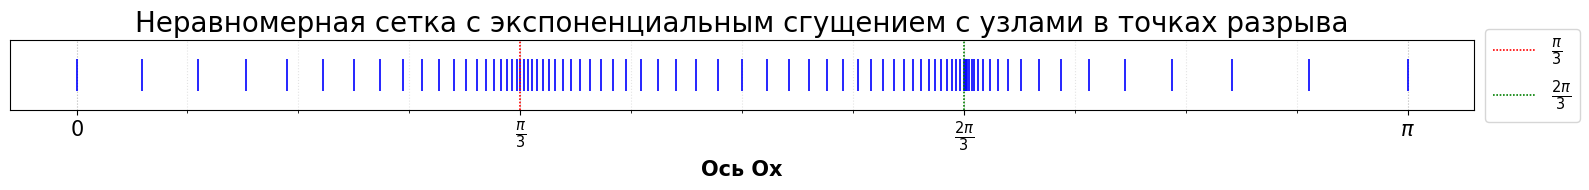

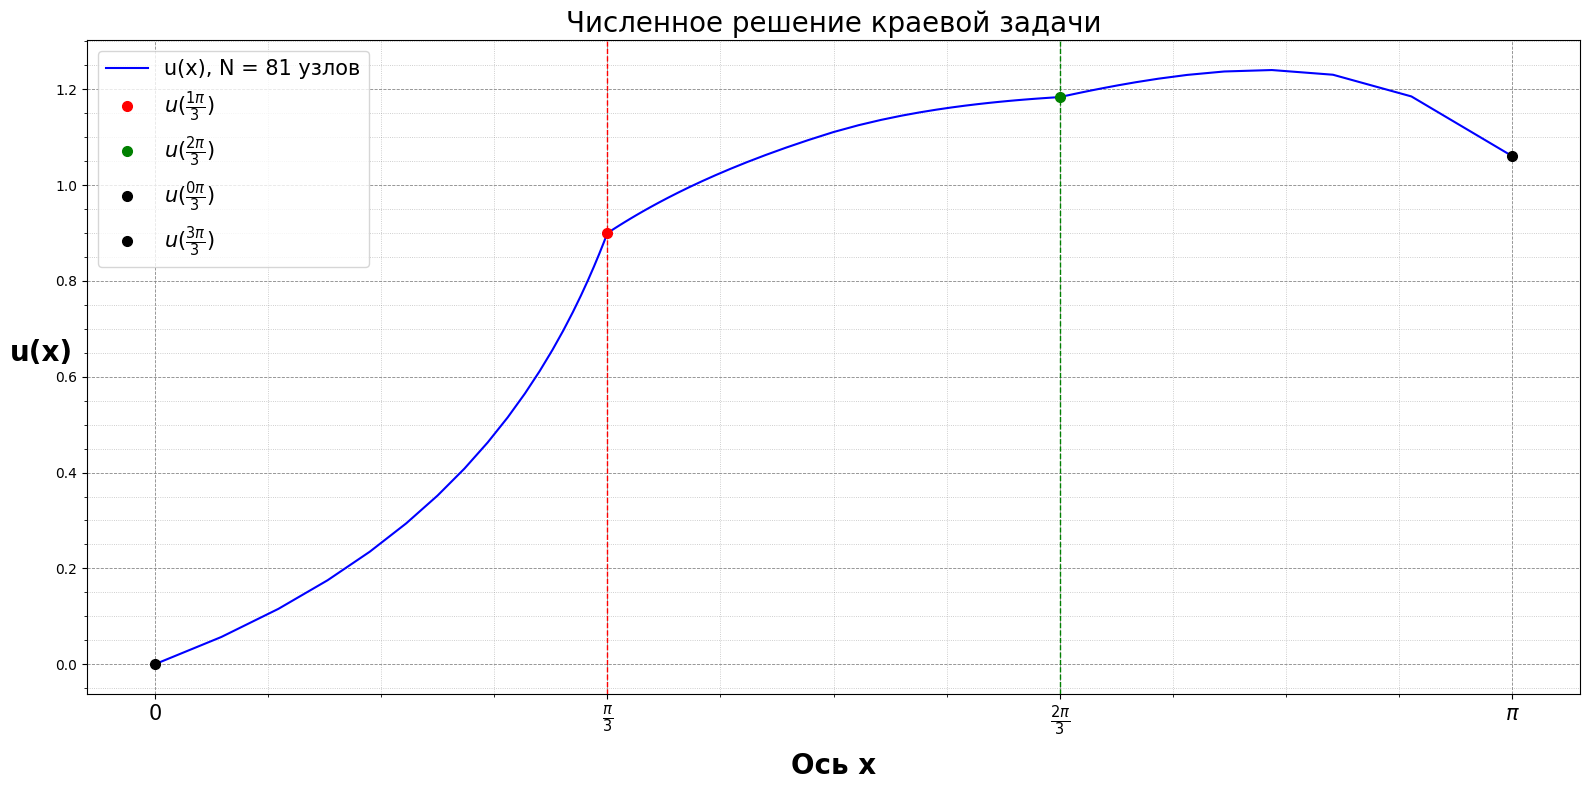

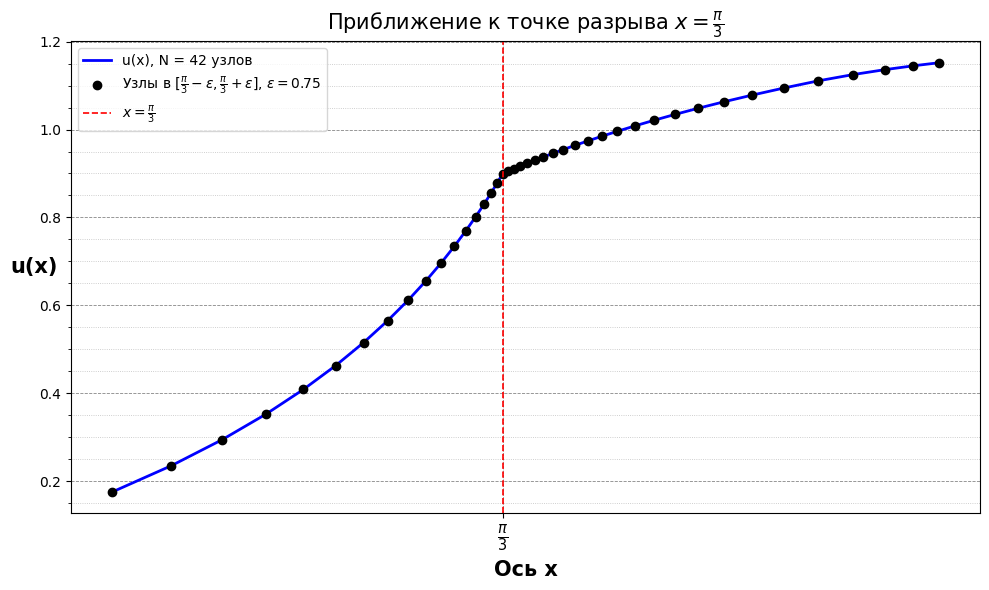

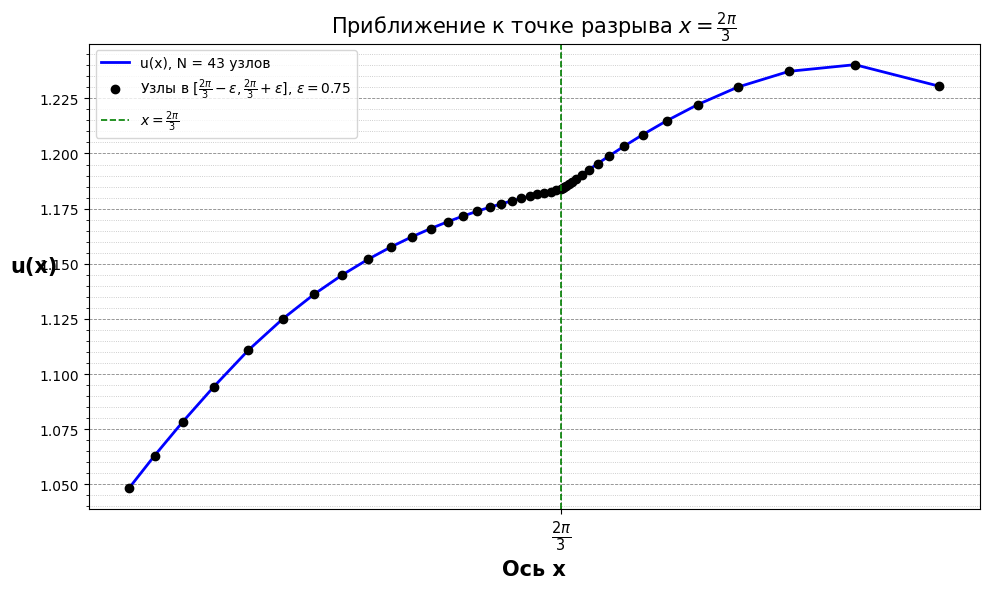

In [2326]:
# Сетка
plot_grid(x)
# Решение
plot_solution(x,u)

# Приближение решения в окрестноти точек разрыва
zoom_around_discontinuity(x, u, np.pi/3, eps, "pi/3")
zoom_around_discontinuity(x, u, 2*np.pi/3, eps, "2pi/3")

# Оценка сходимости методом Рунге

In [2327]:
def linear_interp(N, u2_vals, r):
    """Линейная интерполяция y(x) по массивам x_vals, y_vals"""
    result = []
    for i in range(N):
      result.append(u2_vals[i*r])
    return result

In [2328]:
def max_norm_error(u1, u2_interp):
    """Вычисление нормы max|u1 - u2_interp|"""
    max_err = 0.0
    for a, b in zip(u1, u2_interp):
        err = abs(a - b)
        if err > max_err:
            max_err = err
    return max_err

In [2329]:
def mse_norm(u):
  mse_norm = 0.0
  for i in range(len(u)):
    mse_norm += u[i]*u[i]
  mse_norm = np.sqrt(mse_norm)
  return mse_norm

In [2330]:
# Метод Рунге для оценки порядка
def runge_convergence(N_coarse):
  r = 2
  x1, u1 = solve_bvp(N_coarse)
  x2, u2 = solve_bvp(N_coarse * r)
  x4, u4 = solve_bvp(N_coarse * r * r)


  # вот здесь неправильно наверно считаю - надо вместо ошибок брать численное решение и искать норму между численным решение и истинным,
  #         но вот как найти истинное решение пока не понял

  # Интерполяция на мелкой сетке к крупной
  u12_interp = linear_interp(N_coarse, u2, r)
  u14_interp = linear_interp(N_coarse, u4, r*r)

  mse_norm_n = mse_norm(u1)
  mse_norm_2n = mse_norm(u2)
  mse_norm_4n = mse_norm(u4)
  rate = np.log2((mse_norm_n - mse_norm_2n) / (mse_norm_2n - mse_norm_4n))

  # error_n = max_norm_error(u1, u2_interp)
  # error_2n = max_norm_error(u1, u2_interp)
  # rate = np.log2( (errors[i-1] - errors[i]) / (errors[i] - errors[i+1]))
  return  rate

In [2331]:
# Оценка сходимости
# Ns = [100, 200, 400, 800]
# for N in Ns:
#   rate = runge_convergence(N)
#   print(f"N={N}: порядок ≈ {rate:.2f}")
#   # print(f"N={N}: error_n = {error_n:.6f}, порядок ≈ {rate:.2f}")

# print(errors)
# for i in range(1,len(errors)-1):
  # rate = np.log2( (errors[i-1] - errors[i]) / (errors[i] - errors[i+1]))
  # print(errors[i-1] - errors[i])
  # print(errors[i] - errors[i+1])